In [1]:
%load_ext cython
%matplotlib_svg
import pandas as pd
import numpy as np
import pylab as pl
import cython

## 推荐算法

### 读入数据

In [2]:
columns = ['user_id', 'movie_id', 'rating']
dtypes = [np.int32, np.int32, np.float]
ratings = pd.read_table('data/movielens.data', 
                      names=columns, 
                      usecols=[0, 1, 2], 
                      dtype=dict(list(zip(columns, dtypes))))
ratings["user_id"] -= 1
ratings["movie_id"] -= 1

In [3]:
u, v, r = ratings.user_id.values, ratings.movie_id.values, ratings.rating.values

#删除评分数少于10的用户和电影
u_count = pd.value_counts(u)
v_count = pd.value_counts(v)
mask = (u_count >= 10)[u].values & (v_count >= 10)[v].values
u, v, r = u[mask], v[mask], r[mask]

In [4]:
def train_test_split(arrays, test_size=0.1):
    np.random.seed(0)
    mask_test = np.random.rand(len(arrays[0])) < test_size
    mask_train = ~mask_test
    
    arrays_train = [arr[mask_train] for arr in arrays]
    arrays_test = [arr[mask_test] for arr in arrays]
    
    return arrays_train + arrays_test

u_train, v_train, r_train, u_test, v_test, r_test = train_test_split([u, v, r])
nu = np.max(u) + 1
nv = np.max(v) + 1
nr = len(u_train)

In [15]:
assert np.all(np.unique(u_train) == np.unique(u))
assert np.all(np.unique(v_train) == np.unique(v))

### 推荐性能评价标准

In [139]:
def rmse_score(y_true, y_pred):
    d = y_true - y_pred
    return np.mean(d**2)**0.5

def r2_score(y_true, y_pred):
    d = y_true - y_pred
    return 1 - (d**2).sum() / ((y_true - y_true.mean())**2).sum()

In [140]:
movies_mean = pd.Series(r_train).groupby(v_train).mean()
r_pred = movies_mean[v_test]

rmse_avg, r2_avg = rmse_score(r_test, r_pred), r2_score(r_test, r_pred)
%C rmse_avg; r2_avg

     rmse_avg              r2_avg      
------------------  -------------------
1.0122857327818662  0.17722524926979077


### 矩阵分解

In [141]:
from scipy import sparse
from scipy.sparse import linalg

r_avg = r_train.mean()

row_idx = np.r_[np.arange(nr), np.arange(nr)]
col_idx = np.r_[u_train, v_train + nu]
values = np.ones_like(row_idx)

A = sparse.coo_matrix((values, (row_idx, col_idx)), shape=(nr, nu+nv))

In [142]:
x = linalg.lsqr(A, r_train - r_avg)[0]

ub = x[:nu]
vb = x[nu:]

In [143]:
r_pred = r_avg + ub[u_test] + vb[v_test]

rmse, r2 = rmse_score(r_test, r_pred), r2_score(r_test, r_pred)
%C rmse; r2

        rmse                  r2        
-------------------  -------------------
0.93056259728693425  0.30471011860212072


In [144]:
r_train2 = r_train - (r_avg + ub[u_train] + vb[v_train])
r_test2  = r_test  - r_pred
arrays = u_train, v_train, r_train2, u_test, v_test, r_test2 #以下的程序从该array元组获取数据

### 使用最小二乘法实现矩阵分解

In [145]:
from scipy import sparse
from scipy.sparse import linalg
import gc

def uv_decompose(arrays, loop_count, k, maxiter, mu, damp):
    u_train, v_train, r_train, u_test, v_test, r_test = arrays

    U = np.random.rand(nu, k) * 0.1 / k**0.5 #❶
    V = np.random.rand(nv, k) * 0.1 / k**0.5

    idxv_col = (u_train[:, None]*k + np.arange(k)).ravel()
    idx_row = np.repeat(np.arange(nr), k)
    Av = sparse.coo_matrix((V[v_train].ravel(), (idx_row, idxv_col)),
                           shape=(nr, nu*k)).tocsr() #❷

    idxu_col = (v_train[:, None]*k + np.arange(k)).ravel()
    Au = sparse.coo_matrix((U[u_train].ravel(), (idx_row, idxu_col)),
                           shape=(nr, nv*k)).tocsr()
    
    best_U, best_V = None, None
    best_rmse = 100.0
    rmse_list = []
    
    for i in range(loop_count):
        U.ravel()[:] = linalg.lsmr(Av, r_train, maxiter=maxiter, damp=damp)[0] #❸
        Au.data[:] = Au.data[:]*(1-mu) + U[u_train].ravel()*mu #❹

        V.ravel()[:] = linalg.lsmr(Au, r_train, maxiter=maxiter, damp=damp)[0]
        Av.data[:] = Av.data[:]*(1-mu) + V[v_train].ravel()*mu

        r_pred = U.dot(V.T)[u_test, v_test] #❺
        rmse = rmse_score(r_test, r_pred)
        rmse_list.append(rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_U, best_V = U.copy(), V.copy()
        gc.collect() #❻
    
    return best_U, best_V, best_rmse, rmse_list

In [146]:
U1, V1, best_rmse1, rmses1 = uv_decompose(arrays,
                            loop_count=20, maxiter=6, k=30, mu=0.4, damp=3.5)
U2, V2, best_rmse2, rmses2 = uv_decompose(arrays,
                            loop_count=20, maxiter=6, k=30, mu=0.4, damp=3.0)
print((best_rmse1, best_rmse2))

0.901107139807 0.904096209664


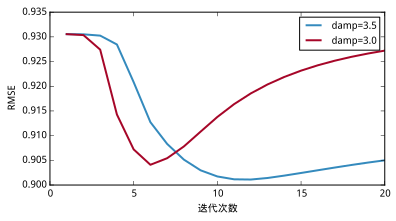

In [147]:
#%fig=damp系数对RMSE的影响
pl.plot(np.arange(1, len(rmses1)+1), rmses1, label="damp=3.5")
pl.plot(np.arange(1, len(rmses2)+1), rmses2, label="damp=3.0")
pl.legend(loc="best")
pl.xlabel("迭代次数")
pl.ylabel("RMSE");

### 使用Cython迭代实现矩阵分解

In [148]:
%%cython
#cython: boundscheck=False
#cython: wraparound=False
import numpy as np

cdef double dot(double[:, ::1] x, double[:, ::1] y, int i, int j):
    cdef int k
    cdef double s = 0
    for k in range(x.shape[1]):
        s += x[i, k] * y[j, k]
    return s

def uv_update(int[::1] userid, int[::1] movieid, double[::1] rating, 
              double[:, ::1] uservalue, double[:, ::1] movievalue,
              double eta, double beta):
    cdef int j, k
    cdef int ratecount = rating.shape[0]
    cdef int uid, mid
    cdef double rvalue, pvalue, error
    cdef double tmp
    cdef int nk = uservalue.shape[1]
    
    for j in range(ratecount):
        uid = userid[j]
        mid = movieid[j]
        rvalue = rating[j]
        pvalue = dot(uservalue, movievalue, uid, mid)
        error = rvalue - pvalue
        for k in range(nk):
            tmp = uservalue[uid, k]
            uservalue[uid, k] += eta * (error * movievalue[mid, k]
                                        - beta * uservalue[uid, k])
            movievalue[mid, k]+= eta * (error * tmp - beta * movievalue[mid, k])

In [149]:
def uv_decompose2(arrays, k, eta, beta, iter_count):
    u_train, v_train, r_train, u_test, v_test, r_test = arrays

    U = np.random.rand(nu, k) * 0.1 / k**0.5
    V = np.random.rand(nv, k) * 0.1 / k**0.5

    best_U, best_V = None, None
    best_rmse = 100.0    
    rmses = []
    idx = np.arange(nr)

    for i in range(iter_count):
        np.random.shuffle(idx)
        uv_update(u_train[idx], v_train[idx], r_train2[idx], U, V, eta, beta)
        t = U.dot(V.T)
        r_pred2 = t[u_test, v_test]
        rmse = rmse_score(r_test, r_pred2)
        rmses.append(rmse)        
        if best_rmse > rmse:
            best_rmse = rmse
            best_U, best_V = U.copy(), V.copy()

    return best_U, best_V, best_rmse, rmses

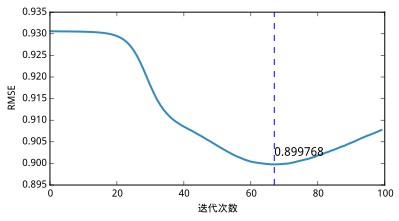

In [190]:
#%fig=随机梯度下降法的收敛曲线
np.random.seed(2)
U3, V3, best_rmse3, rmses3 = uv_decompose2(arrays, 30, 0.008, 0.08, 100)
pl.plot(rmses3)
idx = np.argmin(rmses3)
pl.axvline(idx, lw=1, ls="--")
pl.ylabel("RMSE")
pl.xlabel("迭代次数")
pl.text(idx, best_rmse3 + 0.002, "%g" % best_rmse3);

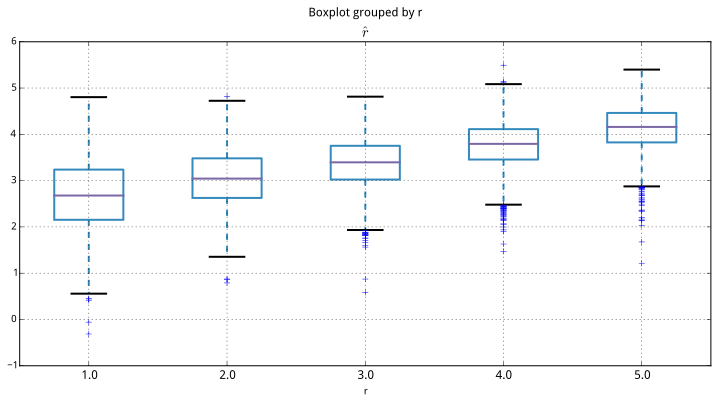

In [191]:
#%fig=以实际评分对预测评分分组，绘制每组的分布情况
r_pred3 = U3.dot(V3.T)[u_test, v_test] + r_pred
s = pd.DataFrame({"r":r_test, "$\hat{r}$":r_pred3})
s.boxplot(column="$\hat{r}$", by="r", figsize=(12, 6));